# 9 Improving performance Exercises Solutions

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Exercise 1

- Reload the IMDB data keeping only the first 20000 most common words
- pad the reviews to a shorter length (eg. 70 or 80), this time make sure you keep the first part of the review if it's longer than the maximum length
- re run the model (remember to set max_features correctly)
- does it train faster this time?
- do you get a better performance?

In [3]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [4]:
max_features = 20000
skip_top = 200

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=max_features,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

17464789/17464789 [==============================] - 41s 2us/step


In [6]:
X_train.shape

(25000,)

In [7]:
maxlen = 80

In [8]:
X_train_pad = pad_sequences(X_train, maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=maxlen, truncating='post')

In [9]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2023-02-01 10:57:39.853963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [11]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Epoch 1/2
547/547 [==============================] - 38s 67ms/step - loss: 0.5074 - accuracy: 0.7469 - val_loss: 0.4139 - val_accuracy: 0.8177
Epoch 2/2
547/547 [==============================] - 36s 67ms/step - loss: 0.3000 - accuracy: 0.8811 - val_loss: 0.4251 - val_accuracy: 0.8243


In [12]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 7s 9ms/step - loss: 0.5043 - accuracy: 0.7841
Test score: 0.5042507648468018
Test accuracy: 0.7840800285339355


## Exercise 2

- Reload the digits data as above
- define a function repeated_training_reg_dropout that adds regularization and dropout to a fully connected network
- compare the performance with/witouth dropout and regularization like we did for batch normalization
- do you get a better performance?

In [13]:
from sklearn.datasets import load_digits
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
import keras.backend as K

In [14]:
digits = load_digits()
X, y = digits.data, digits.target
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [15]:
def repeated_training_reg_dropout(X_train,
                                  y_train,
                                  X_test,
                                  y_test,
                                  units=512,
                                  activation='sigmoid',
                                  optimizer='sgd',
                                  do_dropout=False,
                                  rate=0.3,
                                  kernel_regularizer='l2',
                                  epochs=10,
                                  repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [16]:
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training_reg_dropout(X_train,
                                                                             y_train,
                                                                             X_test,
                                                                             y_test,
                                                                             do_dropout=False)

0 1 2 


In [17]:
mean_acc_do, std_acc_do, mean_acc_val_do, std_acc_val_do = repeated_training_reg_dropout(X_train,
                                                                                         y_train,
                                                                                         X_test,
                                                                                         y_test,
                                                                                         do_dropout=True)

0 1 2 


In [18]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

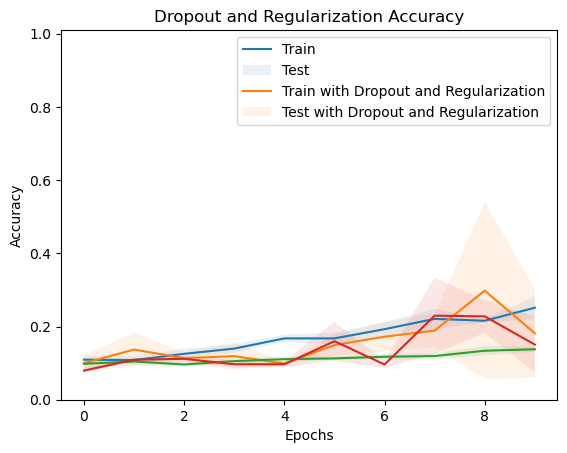

In [19]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_do, std_acc_do)
plot_mean_std(mean_acc_val_do, std_acc_val_do)
plt.ylim(0, 1.01)
plt.title("Dropout and Regularization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Dropout and Regularization', 'Test with Dropout and Regularization'], loc='best')

## Exercise 3

This is a very long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost. Also, feel free to run this with a GPU, in which case you don't need to download the data.

If you are running this locally, download and unpack the male/female pictures from [here](https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0). These images and labels were obtained from [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the ImageDataGenerator. Since you are streaming and augmenting the data in real time you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy)
- Once you are satisfied with your training, check a few of the misclassified pictures. Are those sensible errors?

In [20]:
# If you are running this locally
# uncomment the next 4 lines to download, extract and set the data path:
# !wget 'https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=1' -O ../data/male_female.tgz
# data_path = '../data/male_female'
# !mkdir -p {data_path}
# !tar -xzvf ../data/male_female.tgz --directory {data_path}

In [21]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from itertools import islice
from keras.preprocessing.image import ImageDataGenerator

In [22]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [23]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                        

In [24]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = train_gen.flow_from_directory(data_path + '/train',
                                      target_size = (64, 64),
                                      batch_size = 16,
                                      class_mode = 'binary')

test = test_gen.flow_from_directory(data_path + '/test',
                                    target_size = (64, 64),
                                    batch_size = 16,
                                    class_mode = 'binary')

In [ ]:
model.fit(train,
          steps_per_epoch = 800,
          epochs = 200,
          validation_data = test,
          validation_steps = 200)

In [ ]:
X_test = []
y_test = []
for ts in islice(test, 50):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [ ]:
y_pred = model.predict_classes(X_test).ravel()

In [ ]:
np.argwhere(y_test != y_pred).ravel()

In [ ]:
plt.imshow(X_test[14])